## Reading data from the STAC API

The Planetary Computer catalogs the datasets we host using [STAC](http://stacspec.org/). We provide a [STAC API](https://github.com/radiantearth/stac-api-spec) endpoint that can be used to search our datasets by space and time. This quickstart will show you how to search for data using our STAC API and open source libraries.

To get started you'll need the [pystac-client](https://github.com/stac-utils/pystac-client) library installed. You can install it via pip:

```
> pip install pystac-client
```

First we'll use pystac-client to open up our STAC API:

In [1]:
from pystac_client import Client

catalog = Client.open("https://planetarycomputer-staging.microsoft.com/api/stac/v1")

This gets us a [STAC Catalog](https://github.com/radiantearth/stac-spec/blob/master/catalog-spec/catalog-spec.md) that we can crawl or search. The Catalog contains [STAC Collections](https://github.com/radiantearth/stac-spec/blob/master/collection-spec/collection-spec.md) for each dataset we have indexed (which is not the yet the entirity of data hosted by the Planetary Computer). Here we list the collection IDs and titles that are available:

In [2]:
collections = catalog.get_children()
for collection in collections:
    print(f"{collection.id} - {collection.title}")

hgb - HGB: Harmonized Global Biomass for 2010
terraclimate - TerraClimate
3dep-seamless - USGS 3DEP Seamless DEMs
sentinel-2-l2a - Sentinel-2 Level-2A
mobi - MoBI: Map of Biodiversity Importance
aster-l1t - ASTER L1T
landsat-8-c2-l2 - Landsat 8 Collection 2 Level-2
hrea - HREA: High Resolution Electricity Access
daymet-monthly-hi - Daymet Monthly Hawaii
daymet-annual-pr - Daymet Annual Puerto Rico
daymet-annual-hi - Daymet Annual Hawaii
daymet-annual-na - Daymet Annual North America
daymet-daily-na - Daymet Daily North America
daymet-daily-pr - Daymet Daily Puerto Rico
daymet-daily-hi - Daymet Daily Hawaii
daymet-monthly-na - Daymet Monthly North America
daymet-monthly-pr - Daymet Monthly Puerto Rico
nasadem - NASADEM HGT v001
naip - NAIP: National Agriculture Imagery Program
mtbs - MTBS: Monitoring Trends in Burn Severity
io-lulc - Esri 10-Meter Land Cover


Collections have information about the [STAC Items](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) they contain. For instance, here we look at the [Bands](https://github.com/stac-extensions/eo#band-object) available for [Landsat 8 Collection 2 Level 2](https://planetarycomputer.microsoft.com/dataset/landsat-8-c2-l2) data:

In [3]:
landsat = catalog.get_child("landsat-8-c2-l2")
for band in landsat.extra_fields["summaries"]["eo:bands"]:
    name = band["name"]
    description = band["description"]
    common_name = "" if "common_name" not in band else f"({band['common_name']})"
    ground_sample_distance = band["gsd"]
    print(f"{name} {common_name}: {description} ({ground_sample_distance}m resolution)")

SR_B1 (coastal): coastal (30m resolution)
SR_B2 (blue): visible blue (30m resolution)
SR_B3 (green): visible green (30m resolution)
SR_B4 (red): visible red (30m resolution)
SR_B5 (nir): near-infrared (30m resolution)
SR_B6 (swir16): short-wave infrared (30m resolution)
SR_B7 (swir22): short-wave infrared (30m resolution)
ST_B10 (lwir11): long-wave infrared (100m resolution)
ST_TRAD : thermal radiance (30m resolution)
ST_URAD : upwelled radiance (30m resolution)
ST_ATRAN : atmospheric transmission (30m resolution)
ST_CDIST : distance to nearest cloud (30m resolution)
ST_DRAD : downwelled radiance (30m resolution)
ST_EMIS : emissivity (30m resolution)
ST_EMSD : emissivity standard deviation (30m resolution)


We can use the API to search for images that overlap an area during a specific time. Here we use an area around Microsoft's main campus in December of 2020:

In [4]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-122.27508544921875, 47.54687159892238],
            [-121.96128845214844, 47.54687159892238],
            [-121.96128845214844, 47.745787772920934],
            [-122.27508544921875, 47.745787772920934],
            [-122.27508544921875, 47.54687159892238],
        ]
    ],
}

time_range = "2020-12-01/2020-12-31"

search = catalog.search(
    collections=["landsat-8-c2-l2"], intersects=area_of_interest, datetime=time_range
)

The search returns us the STAC Items as [PySTAC](https://pystac.readthedocs.io/en/latest/) objects:

In [5]:
items = list(search.get_items())
for item in items:
    print(f"{item.id}: {item.datetime}")

LC08_L2SP_046027_20201229_02_T2: 2020-12-29 18:55:56.738265+00:00
LC08_L2SP_047027_20201220_02_T2: 2020-12-20 19:02:09.878796+00:00
LC08_L2SP_046027_20201213_02_T2: 2020-12-13 18:56:00.096447+00:00
LC08_L2SP_047027_20201204_02_T1: 2020-12-04 19:02:11.194486+00:00


We can use the `eo` extension to sort the items by cloudiness. We'll grab an item with low cloudiness:

In [6]:
selected_item = sorted(items, key=lambda item: item.properties["eo:cloud_cover"])[0]

We can see what [Assets](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md#asset-object) are available on our item with:

In [7]:
for asset_key, asset in selected_item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

ANG                       - Angle Coefficients File
SR_B1                     - Coastal/Aerosol Band (B1)
SR_B2                     - Blue Band (B2)
SR_B3                     - Green Band (B3)
SR_B4                     - Red Band (B4)
SR_B5                     - Near Infrared Band 0.8 (B5)
SR_B6                     - Short-wave Infrared Band 1.6 (B6)
SR_B7                     - Short-wave Infrared Band 2.2 (B7)
ST_QA                     - Surface Temperature Quality Assessment Band
ST_B10                    - Surface Temperature Band (B10)
MTL.txt                   - Product Metadata File
MTL.xml                   - Product Metadata File (xml)
ST_DRAD                   - Downwelled Radiance Band
ST_EMIS                   - Emissivity Band
ST_EMSD                   - Emissivity Standard Deviation Band
ST_TRAD                   - Thermal Radiance Band
ST_URAD                   - Upwelled Radiance Band
MTL.json                  - Product Metadata File (json)
QA_PIXEL                  - Pi

Here we inspect the `thumbnail` asset:

In [8]:
import json

thumbnail_asset = selected_item.assets["thumbnail"]
print(json.dumps(thumbnail_asset.to_dict(), indent=2))

{
  "href": "https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2020/047/027/LC08_L2SP_047027_20201204_20210313_02_T1/LC08_L2SP_047027_20201204_20210313_02_T1_thumb_small.jpeg",
  "type": "image/jpeg",
  "title": "Thumbnail image"
}


You can see the URL of the of the thumbnail is contained in the Asset information. However, we won't be able to use the URL directly as-is:

In [9]:
import requests

requests.get(thumbnail_asset.href)

<Response [404]>

That's because the Plantary Computer uses Azure Blob Storage [SAS Tokens](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview#how-a-shared-access-signature-works) to enable access to our data, which allows us to provide the data for free to anyone, anywhere while maintaining some control over the amount of egress for datasets.

To get a token for access, you can use the Planetary Computer's [Data Authentication API](../reference/sas.md).

You can also use the [planetary-computer](https://github.com/microsoft/planetary-computer-sdk-for-python) package to generate tokens and sign asset HREFs for access. You can install via pip with

```
> pip install planetary-computer
```

In [10]:
import planetary_computer as pc

signed_href = pc.sign(thumbnail_asset.href)

We can use PIL to render the image:

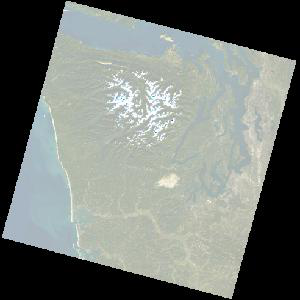

In [11]:
from PIL import Image
from urllib.request import urlopen

Image.open(urlopen(signed_href))